<a href="https://colab.research.google.com/github/angli66/3D-reconstruction-demo/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Preparation

This approach will be mostly based on OpenCV library. the original OpenCV version of Colab doesn't have full support of the function that we will be using. To have full support we will need to install OpenCV of version 4.5.4 manually. We will also install a package named pypotree, which is a light-weight 3D visualization package that enables naive visualization on Colab. Open3d will be used to remove outliers in the final step. The following commands are used to install these packages:

In [ ]:
# Install packages that we will use in the project
!pip install opencv-contrib-python==4.5.4.60
!pip install pypotree
!pip install open3d

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pypotree
import open3d as o3d

Below are some useful helper functions derived from previous homeworks that help us convert between Euclidean coordinates and homogeneous coordinates and help us visualize correspondences.

In [ ]:
# Helper functions
def to_homog(points):
    """
    Function: convert points from Euclidean coordinates to homogeneous coordinates
    points: 3xn numpy array containing Euclidean coordinates
    Return: 4xn numpy array containing homogeneous coordinates
    """
    m, n = points.shape
    points_homog = np.concatenate([points, np.ones([1, n])], axis=0)
    return points_homog

def from_homog(points_homog):
    """
    Function: convert points from homogeneous coordinates to Eulidean coordinates
    points_homog: 4xn numpy array containing homogeneous coordinates
    Return: 3xn numpy array containing Euclidean coordinates
    """
    m, n = points_homog.shape
    points = points_homog[:m-1] / points_homog[m-1]
    return points

def hstack_images(img1, img2):
    """
    Function: stacks 2 images side-by-side
    img1, img2: two input images
    Return: stacked image
    """
    H = max(img1.shape[0], img2.shape[0])
    W = img1.shape[1] + img2.shape[1]
    img = np.zeros((H, W, 3), dtype=img1.dtype)
    img[:img1.shape[0], :img1.shape[1], :] = img1
    img[:img2.shape[0], img1.shape[1]:, :] = img2
    return img

def vis_correspondence(img1, img2, S1, S2):
    """
    Function: visualizes corresponding points between two images
    img1, img2: two input images
    S1: 2xn numpy array containing points in image 1
    S2: 2xn numpy array containing points in image 2 that corresponds to points in image 1
    """
    img = hstack_images(img1, img2)
    x_shift = img1.shape[1]
    S1 = S1.astype(np.int)  # Shape: [2, n].
    S2 = S2.astype(np.int)  # Shape: [2, n].
    np.random.seed(0)
    colors = np.random.rand(S1.shape[1], 3)
    if img.dtype == np.uint8:
      colors *= 255

    # Draw figure. 
    for p1, p2, color in zip(S1.T, S2.T, colors):
      x1, y1 = p1
      x2, y2 = p2
      img = cv.circle(img, (x1, y1), 5, color, -1)
      img = cv.circle(img, (x2 + x_shift, y2), 5, color, -1)
      img = cv.line(img, (x1, y1), (x2 + x_shift, y2), color, 2, cv.LINE_AA)
    plt.figure(figsize=(16, 12))
    plt.title('Visualize correspondences')
    plt.imshow(img)
    plt.show()

Then we load the data set into our runtime:

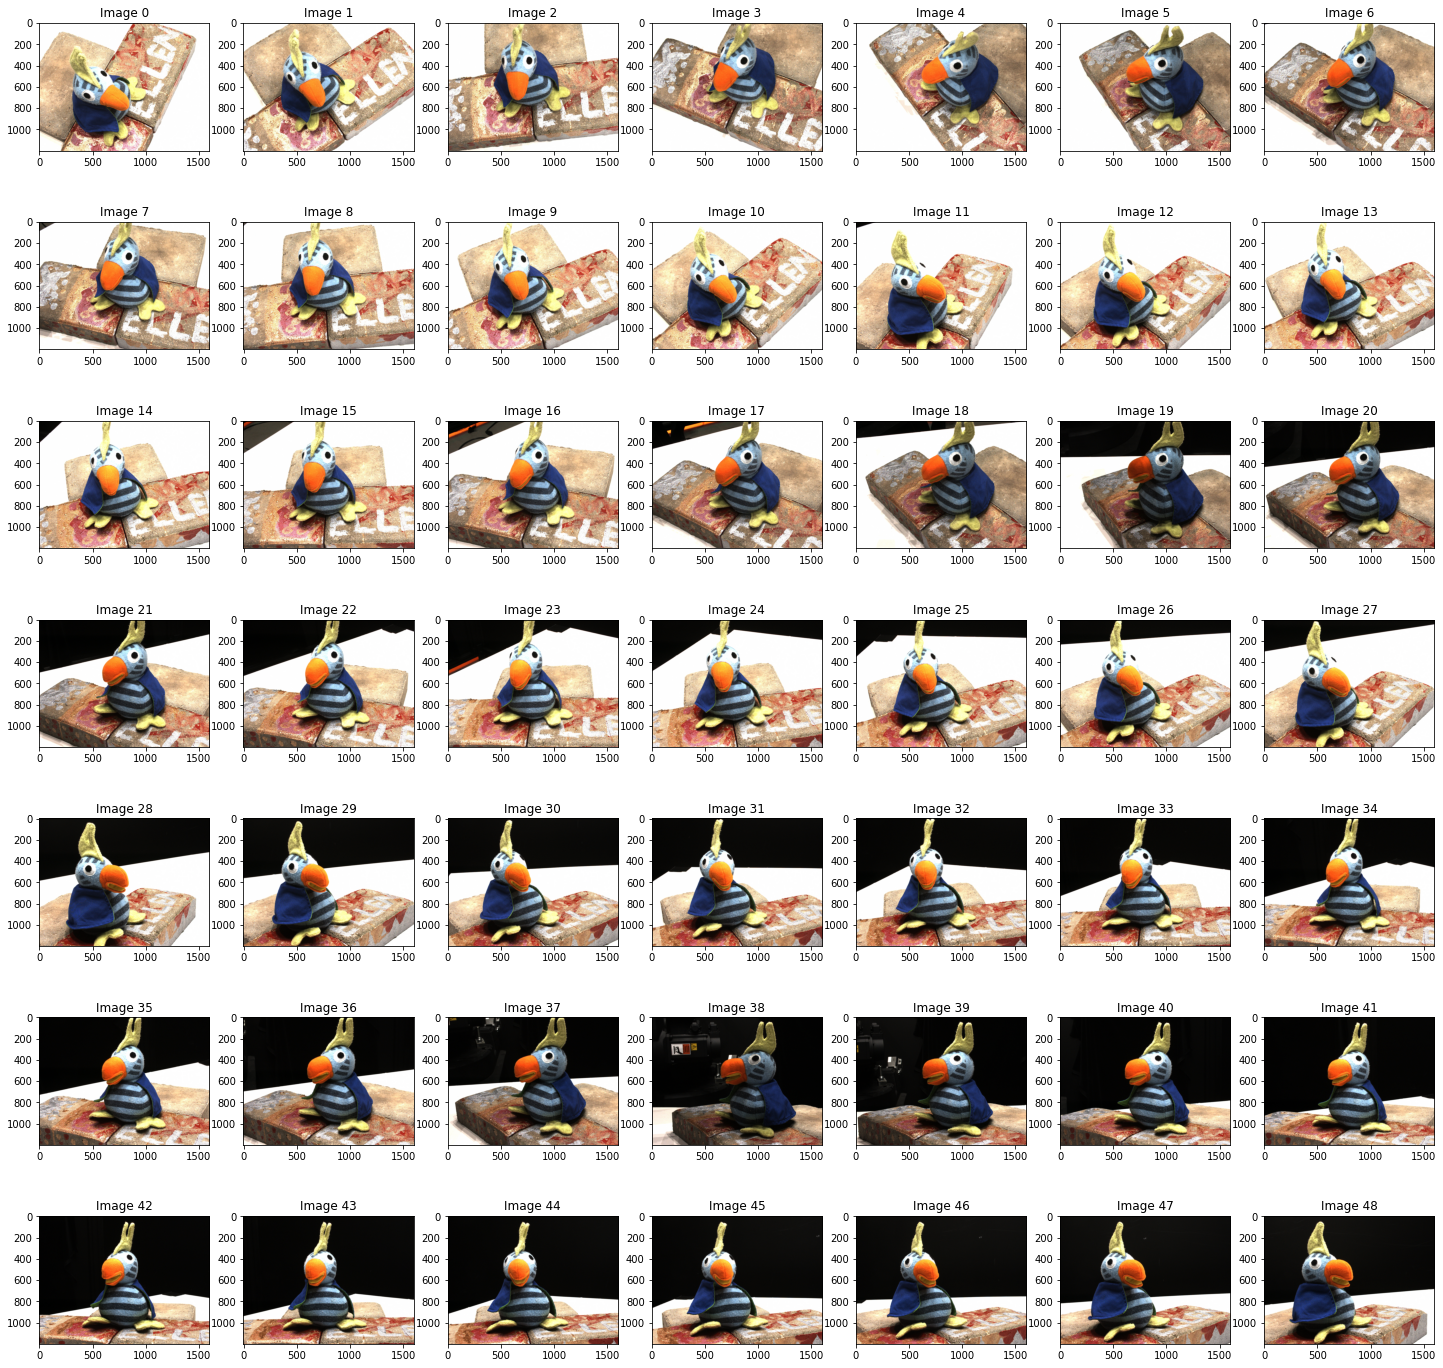

In [ ]:
# Load images into a list
images = []
for i in range(49):
    image = cv.imread(f'./final_project_data/images/{i}.jpg') # Use cv.imread instead of plt.imread so that we can directly use cv functions afterwards
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # cv.imread save data in BGR order by default, change it into RGB
    images.append(image)

# Preview of images
fig = plt.figure(figsize=(25, 25))
row = 7
col = 7
for i in range(row * col):
    ax = fig.add_subplot(row, col, i+1)
    ax.title.set_text(f'Image {i}')
    plt.imshow(images[i])
plt.show()

In [ ]:
# Load intrinsic and extrinsic matrices
intrinsics = np.load('./final_project_data/intrinsics.npy')
extrinsics = np.load('./final_project_data/extrinsics.npy')

# 2 Identify Points of Interests
The very first step of 3D reconstruction is to identify points of interests in images. In homework we built a Shi-Tomasi corner detector which is able to detect corner points in images. In this approach we will use a stronger dectection algorithm called SIFT provided by OpenCV. The basic idea of SIFT is similar to Shi-Tomasi, instead while Shi-Tomasi is rotation-invariant (which means even if the image is rotated we can still find the same corners), SIFT is rotation-invariant and scaling-invariant (even if the image is scaled the same corners can still be found). For more information and usages, refers to [https://docs.opencv.org/4.5.4/da/df5/tutorial_py_sift_intro.html](https://docs.opencv.org/4.5.4/da/df5/tutorial_py_sift_intro.html).

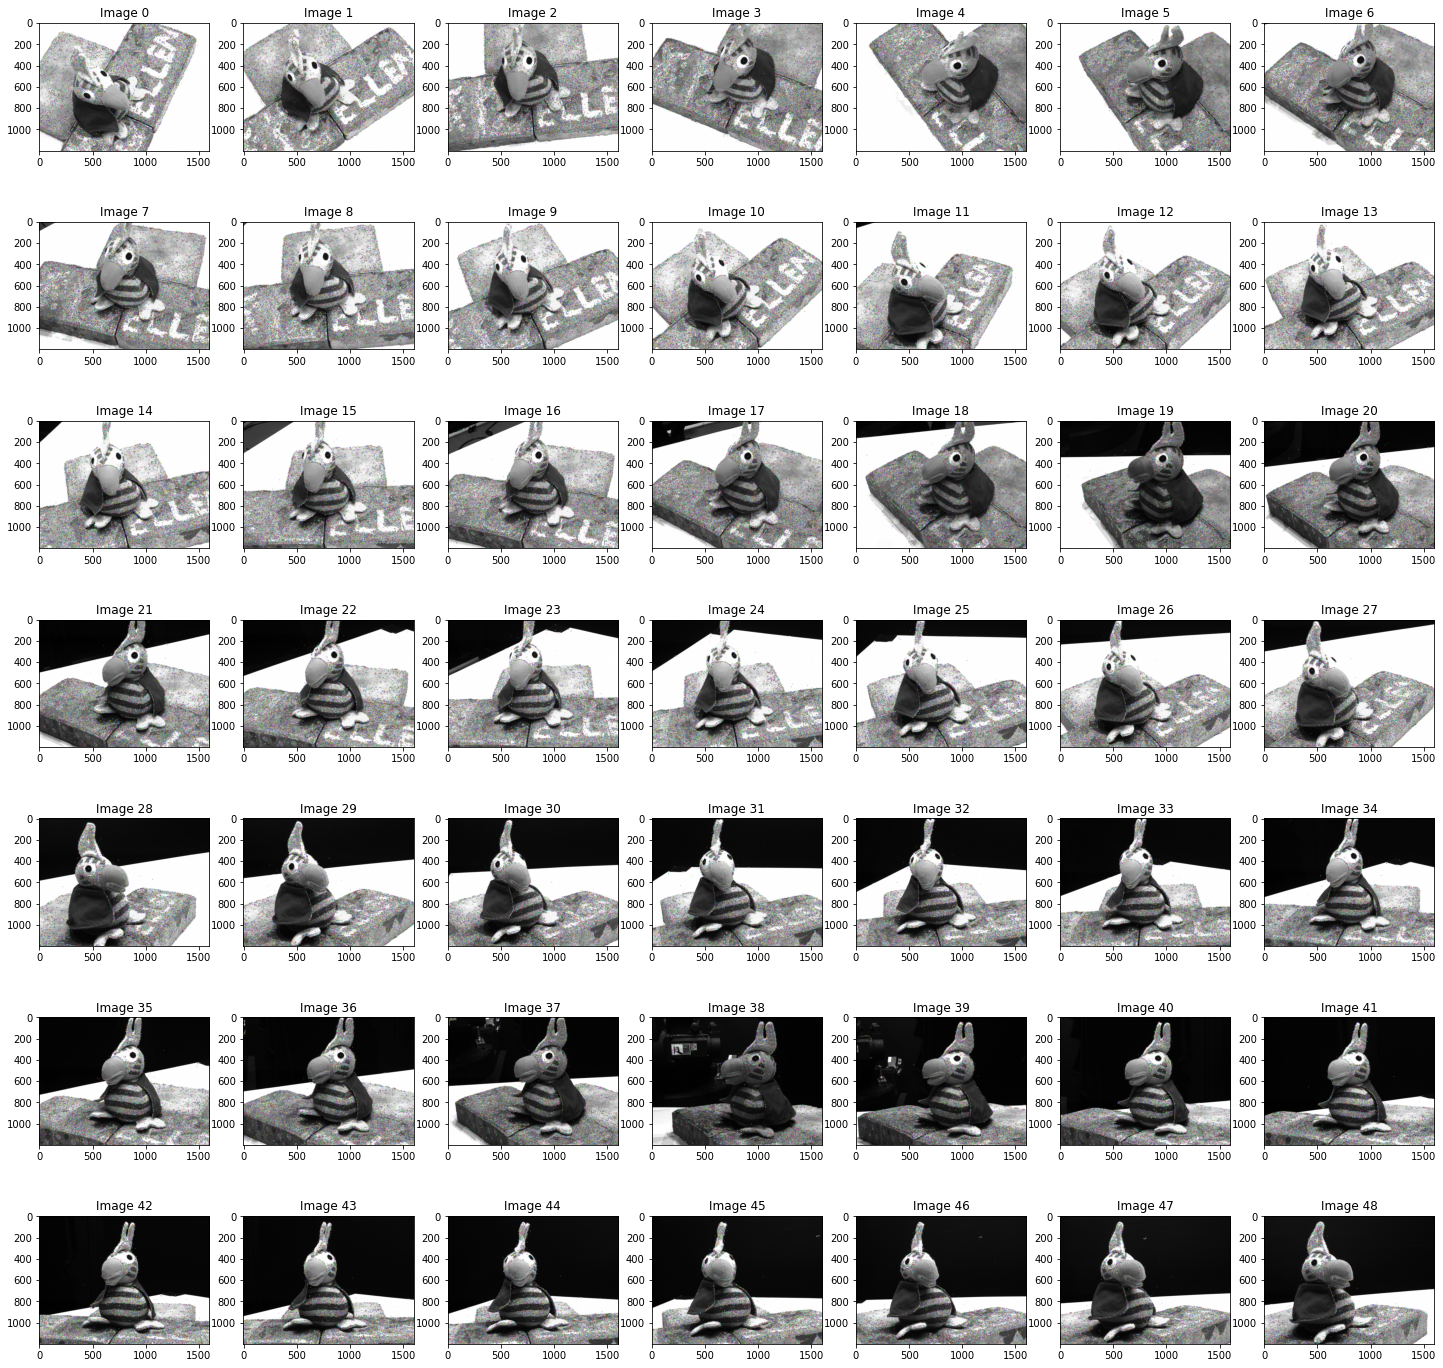

In [ ]:
# Use SIFT to detect key points in images and compute descriptors for those key points
keypoints = []
descriptors = []
outputs = []

for i, image in enumerate(images):
    gray_image = cv.cvtColor(image,cv.COLOR_RGB2GRAY) # Convert image to grayscale
    sift = cv.SIFT_create()
    keypoint, descriptor = sift.detectAndCompute(gray_image, None)
    output = cv.drawKeypoints(gray_image, keypoint, None)
    keypoints.append(keypoint)
    descriptors.append(descriptor)
    outputs.append(output)

# Preview of images
fig = plt.figure(figsize=(25, 25))
row = 7
col = 7
for i in range(row * col):
    ax = fig.add_subplot(row, col, i+1)
    ax.title.set_text(f'Image {i}')
    plt.imshow(outputs[i])
plt.show()

# 3 3D Reconstruction with Two Cameras

After getting key points of our image set we can formally start to build reconstruction. To begin with, let's first try to build the reconstruction with two images. We want to choose two images from our image set, derive the correspondences between their key points, and do triangulation according to the extrinsic/intrinsic matrices and correspondences to reconstruct 3D points. Since every two neighboring images in our dataset are also photoed by neighboring cameras, we can start with image 0 and image 1. We add images one by one later.

To derive correspondence between two images, we will have to select a feature descriptor and use it to compare the distance between any two pairs of key points across two images. In lectures we introduced SSD and NCC. In the previous section we've already derived descriptors for key points returned by SIFT, which are much stronger descriptors than SSD and NCC. We'll be passing it to OpenCV's matching algorithm in this section. [https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html) has a nice tutorial of how to achieve this. It also includes a tutorial of how to increase the robustness of the result by adding a ratio test.

## 3.1 Search for Corresponding Points across two images

In [ ]:
def get_corresondence(img1, img2, kp1, kp2, des1, des2):
    """
    Function: get correspondence across two images
    img1, img2: two input images
    kp1, kp2: keypoints of img1 and img2
    des1, des2: descriptors of img1 and img2
    Return: two 2xn numpy array that contains corresponding points after validation
    """
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:
            good_matches.append([m])

    # Extract points from good_matches into two 2xn numpy arrays for future calculation
    pts1_list = []
    pts2_list = []

    for match in good_matches:
        pts1_list.append(kp1[match[0].queryIdx].pt)
        pts2_list.append(kp2[match[0].trainIdx].pt)

    pts1 = np.array(pts1_list).T
    pts2 = np.array(pts2_list).T

    return pts1, pts2

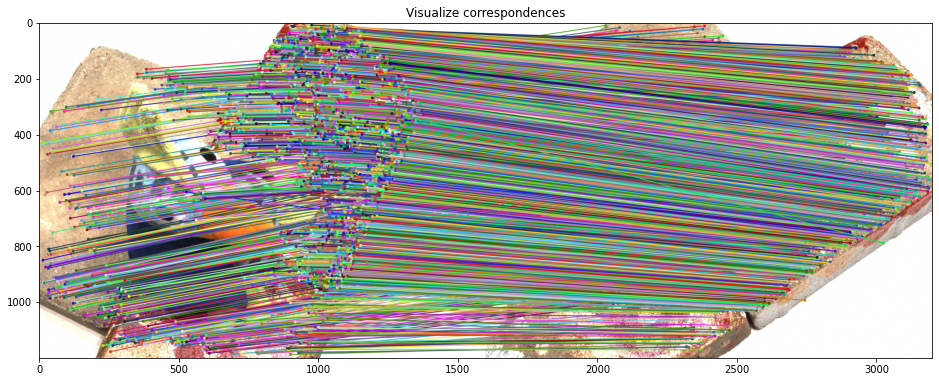

Number of correspondences derived: 2843


In [ ]:
# Get corresondence of image 0 and image 1
pts1, pts2 = get_corresondence(images[0], images[1], keypoints[0], keypoints[1], descriptors[0], descriptors[1])

# Visualize correspondence
vis_correspondence(images[0], images[1], pts1, pts2)
print("Number of correspondences derived: %d" % (len(pts1[0])))

## 3.2 Triangulation

After that, we can use the correspondence to reconstruct 3D points through triangulation. The optimization approach that we've introduced in class can be used, but a simpler approach is to use a function called `triangulatePoints` in OpenCV library to achieve this. `triangulatePoints` takes in four parameters, which are the two projection matrices (camera matrices) and the two corresponding points arrays. All we have to do here is to calculate the projection matrices via intrinsic and extrinsic matrices, and pass it together with the correspendence we derived to `triangulatePoints`. 

In [ ]:
def reconstruct(pts1, pts2, int1, int2, ext1, ext2):
    """
    Function: reconstruct 3D points with given correspondence
    int1, int2: intrinsic matrices of camera 1 and camera 2
    ext1, ext2: extrinsic matrices of camera 1 and camera 2
    Return: 3xn numpy arrays containing the Euclidean coordinates of reconstructed 3D points
    """
    # Calculate projection matrices for two cameras
    proj1 = int1 @ np.hstack((np.eye(3), np.zeros((3, 1)))) @ ext1
    proj2 = int2 @ np.hstack((np.eye(3), np.zeros((3, 1)))) @ ext2

    # Reconstruct through triangulation
    recon_h = cv.triangulatePoints(proj1, proj2, pts1, pts2)
    recon = from_homog(recon_h)

    return recon

In [ ]:
# Reconstruct 3D points
recon = reconstruct(pts1, pts2, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

Let's see the visualization of our results using pypotree:

In [ ]:
# Visualizing reconstruction results
cloudpath = pypotree.generate_cloud_for_display(-recon.T) # pypotree takes in nx3 numpy array, add negative to reverse axis
pypotree.display_cloud_colab(cloudpath)

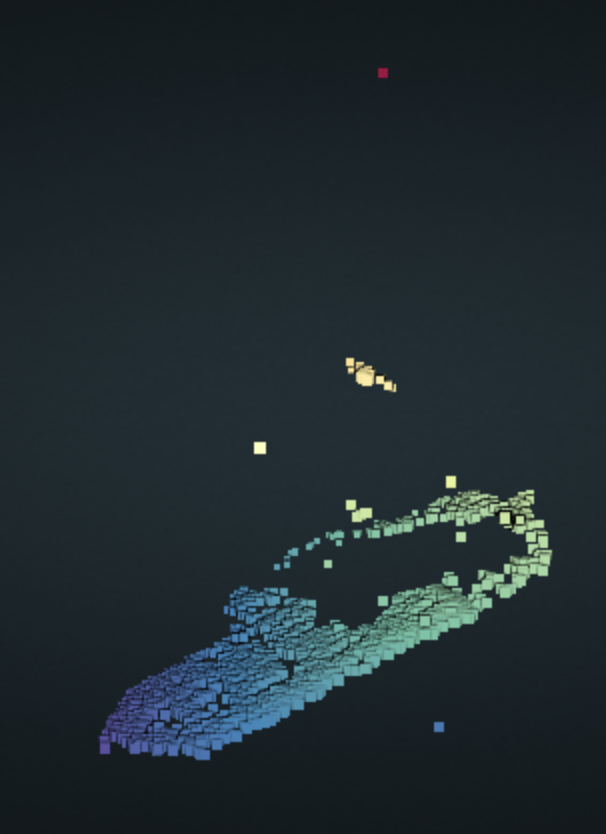

(With parameter 0.6 in ratio test)

# 4 3D Reconstruction with Multiple Cameras

## 4.1 Validate Correspondence

Before adding more images into scope, let's first take a look at validating the correspondence. The plain correspondence we derived above might include some noises. This might not be obvious when we are only building the reconstruction with two images, but as we increase our data set size, the error will accumulate and bring a large number of false correspondence. A good idea is to use fundamental matrix to remove outliers. We can use the approach we've implemented in HW5. However, here we don't have to use RANSAC as we already have the intrinsic and extrinsic matrices of the cameras, which enables us to derive the ground-truth fundamental matrix. All we have to do is to get the fundamental matrix with given intrinsic and extrinsic matrix, and then use it to remove outliers without iterations. The formula for calculating fundamental matrix is
$$F = K_1^{-T}([t]_{\times}R)K_2^{-1}$$
where
$$
[t]_{\times} = 
\begin{bmatrix}
0 & -t_3 & t_2 \\
t_3 & 0 & -t_1 \\
-t_2 & t_1 & 0
\end{bmatrix}
$$

In [ ]:
def validate_correspondence(pts1, pts2, int1, int2, ext1, ext2):
    """
    Function: validate corespondence via fundamental matrix
    pts1, pts2: two 2xn numpy arrays containing the original correspondence
    int1, int2: intrinsic matrices of camera 1 and camera 2
    ext1, ext2: extrinsic matrices of camera 1 and camera 2
    Return: two 2xn numpy array that contains corresponding points after validation
    """
    # Caculate fundamental matrix from camera matrices
    ext_1_to_2 = ext2 @ np.linalg.inv(ext1)
    R = ext_1_to_2[:3, :3]
    t = ext_1_to_2[:3, 3]
    tx = np.array([
                [0, -t[2], t[1]],
                [t[2], 0, -t[0]],
                [-t[1], t[0], 0]
    ])
    E = tx @ R
    F = np.linalg.inv(int1).T @ E @ np.linalg.inv(int2)

    # Remove outliers with fundamental matrix
    inliers_ind = []
    thres = 25.0 # Threshold for determining inliers
    for i in range(len(pts1[0])):
        p1 = pts1[:, i].reshape(2, 1)
        p2 = pts2[:, i].reshape(2, 1)
        p1_h = to_homog(p1)
        p2_h = to_homog(p2)
        if np.linalg.norm(p1_h.T @ F @ p2_h) < thres:
            inliers_ind.append(i)

    pts1_inliers = pts1[:, inliers_ind]
    pts2_inliers = pts2[:, inliers_ind]

    return pts1_inliers, pts2_inliers

Correspondence after validation:


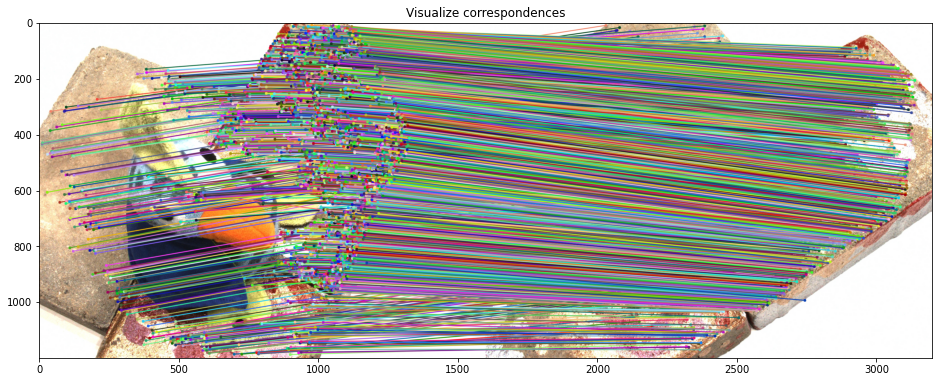

Number of correspondences after validation: 2587


In [ ]:
# Validate correspondence via camera matrices
pts1_inliers, pts2_inliers = validate_correspondence(pts1, pts2, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

# Visualize correspondence after validation
print("Correspondence after validation:")
vis_correspondence(images[0], images[1], pts1_inliers, pts2_inliers)
print("Number of correspondences after validation: %d" % (len(pts1_inliers[0])))

The smaller the threshold, the fewer correspondences are preserved. While decreasing the threshold enable us to remove noises, it might also remove some correct correspondence. Let's use our cleaned correspondence to do reconstruction and visualize it again:

In [ ]:
# Reconstruct 3D points with cleaner visualization
recon = reconstruct(pts1_inliers, pts2_inliers, intrinsics[0], intrinsics[1], extrinsics[0], extrinsics[1])

# Visualizing reconstruction results
cloudpath2 = pypotree.generate_cloud_for_display(-recon.T)
pypotree.display_cloud_colab(cloudpath2)

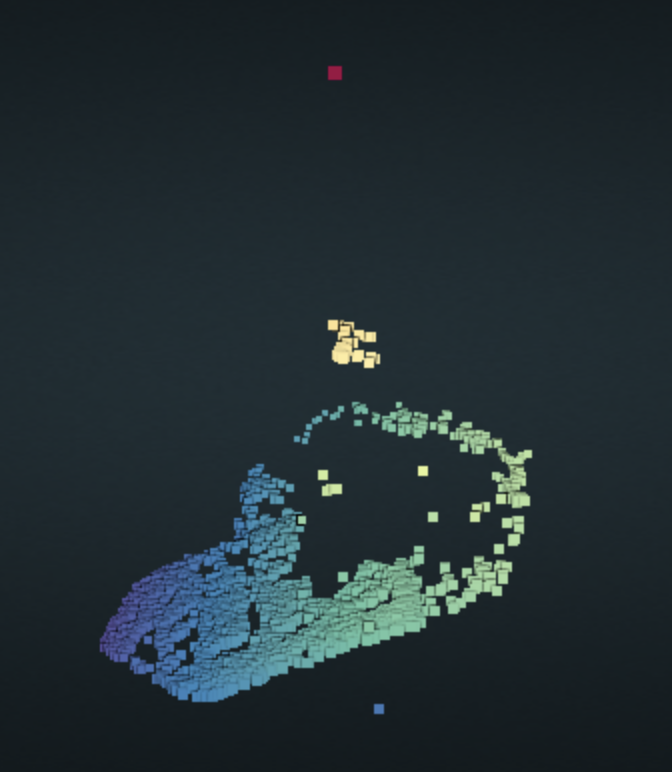

(With a threshold of 25.0 in validating correspondences)

I set a relatively large threshold which only removes a small number of points that are too far away from the ground truth. This is due to the cleaness of our dataset, where correspondence derived by the code above is mostly correct. Using fundamental matrix to remove outliers is basically a trade-off between accuracy and number of points preserved. To preserve as many correct reconstructed points as possible, we use a large threshold here and use some other approaches in the final section to remove outliers. 

## 4.2 Adding More Cameras

The idea of including more cameras is simple: since every two neighboring images are photoed by neighboring cameras, which means it is possible to get a fair correspondence between every two neighboring images, we can do a sequence of matching-validating-triangulating on every pair of neighboring images (image 0 and 1, 1 and 2, 2 and 3, etc.) and put all of the points we calculated together. Since we have 49 images, which gives us 50 neighboring pairs, it is fair to expect getting over 10x reconstructed points than only using two images.

In [ ]:
# Include the whole data set
for i in range (1, 48):
    print("Resconstructing from image %d and %d..." % (i, i+1))
    pts1, pts2 = get_corresondence(images[i], images[i+1], keypoints[i], keypoints[i+1], descriptors[i], descriptors[i+1])
    pts1_inliers, pts2_inliers = validate_correspondence(pts1, pts2, intrinsics[i], intrinsics[i+1], extrinsics[i], extrinsics[i+1])
    recon_next = reconstruct(pts1_inliers, pts2_inliers, intrinsics[i], intrinsics[1+1], extrinsics[i], extrinsics[i+1])
    recon = np.hstack([recon, recon_next])

In [ ]:
# Visualizing reconstruction results
cloudpath3 = pypotree.generate_cloud_for_display(-recon.T)
pypotree.display_cloud_colab(cloudpath3)

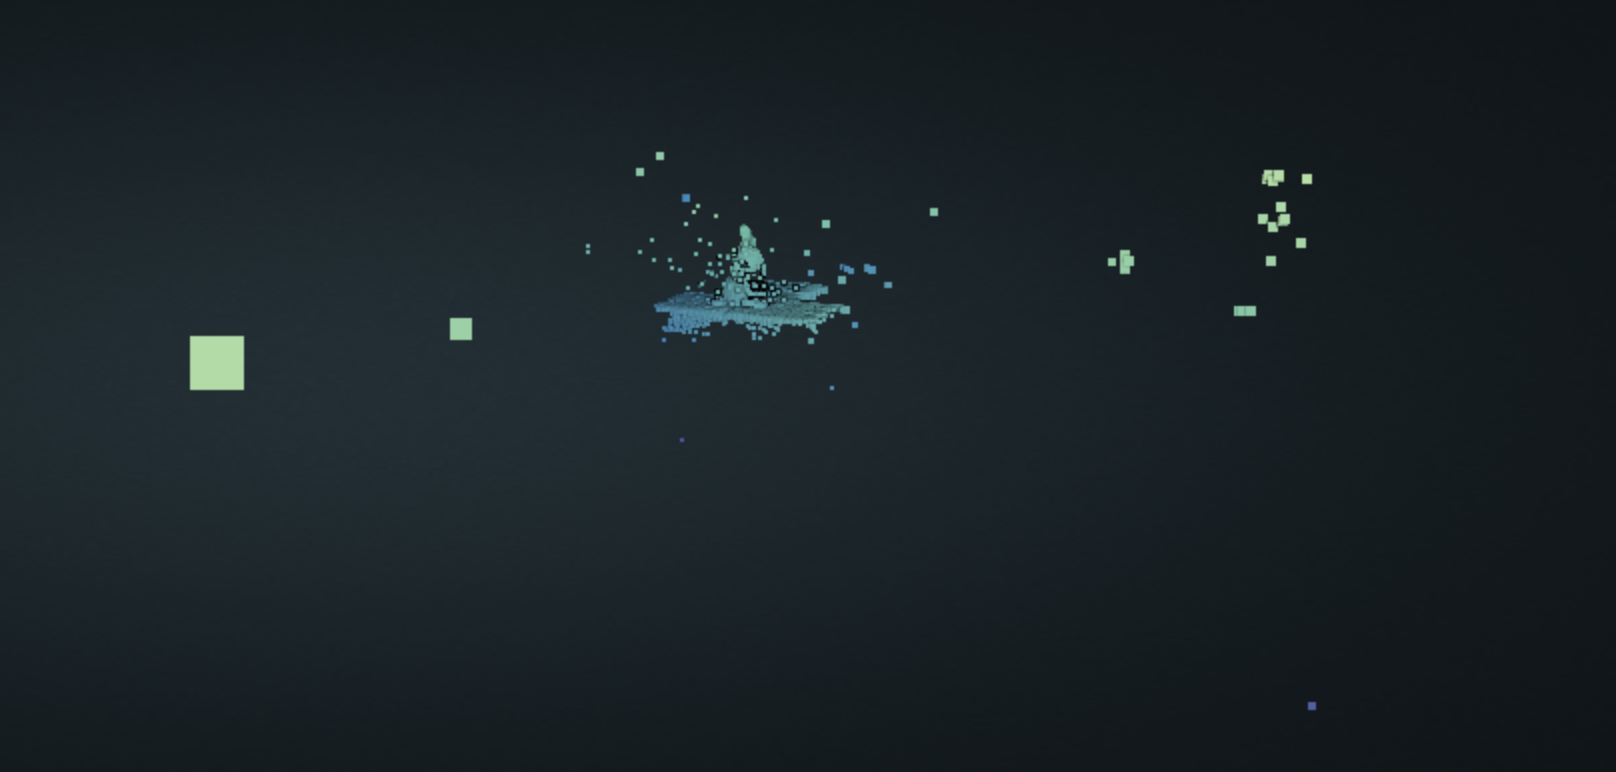

There are quite a lot outliers, and the next step is to remove then as much as possible.

# 5 Outliers Removal

We will be using `remove_statistical_outlier` from Open3d to remove outliers. The idea of the function is to removes points that are further away from their neighbors compared to the average for the point cloud. The details of the function can be found here: [http://www.open3d.org/docs/release/tutorial/geometry/pointcloud_outlier_removal.html?highlight=remove_statistical_outliers](http://www.open3d.org/docs/release/tutorial/geometry/pointcloud_outlier_removal.html?highlight=remove_statistical_outliers). We do this process twice: the first time is to remove outliers that are obviously deviated from the center, and the second time is a deeper clean on unreliable points.

In [ ]:
print("Number of 3d points before removal: %d" % (recon.T.shape[0]))

# First clean
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(recon.T)
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=100, std_ratio=10.0)
pcd = pcd.select_by_index(ind)
recon_cleaned = np.asarray(pcd.points)
print("Number of 3d points after first clean: %d" % (recon_cleaned.shape[0]))

# Second clean
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = pcd.select_by_index(ind)
recon_refined = np.asarray(pcd.points)
print("Number of 3d points after first clean: %d" % (recon_refined.shape[0]))

In [ ]:
# Visualizing reconstruction results
cloudpath4 = pypotree.generate_cloud_for_display(-recon_refined)
pypotree.display_cloud_colab(cloudpath4)

Final Result

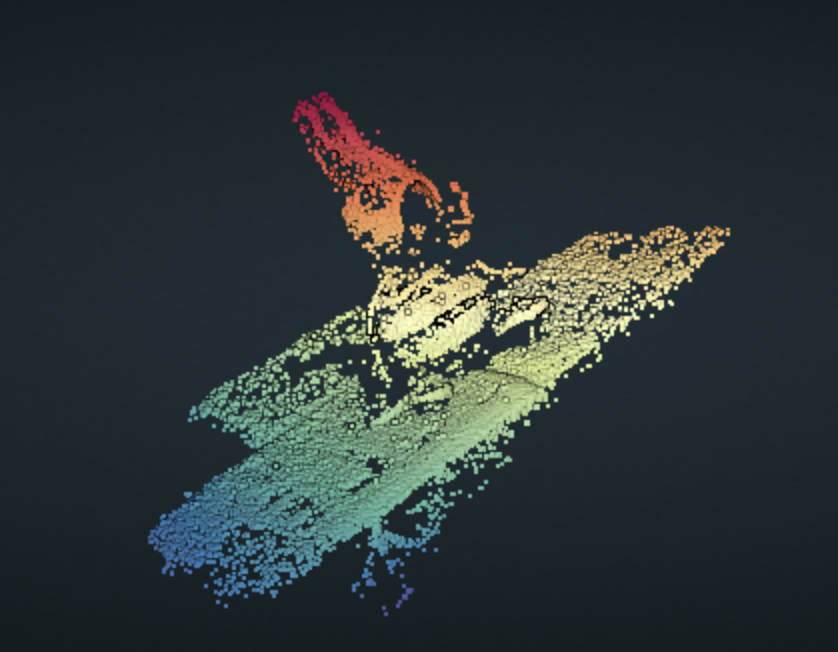